In [1]:
import pandas as pd
import numpy as np

cds_tab = pd.read_csv(
    '../data/CCDS.current.txt.gz', # downloaded 4th of May 2025
    sep = '\t',
    compression = 'gzip'
)
    
cds_tab = cds_tab.loc[cds_tab.ccds_status.str.match('Public')]
for column in ['cds_from', 'cds_to']:
    cds_tab.loc[:, column] = cds_tab[column].apply(
        lambda x: int(x) if x.isnumeric() else 0
    )
    
cds_tab['cds_length'] = cds_tab.cds_to - cds_tab.cds_from
cds_tab = cds_tab.loc[cds_tab.groupby('gene_id')['cds_length'].idxmax()]
cds_tab.set_index('ccds_id', inplace=True)
cds_tab

,#chromosome,nc_accession,gene,gene_id,ccds_status,cds_strand,cds_from,cds_to,cds_locations,match_type,cds_length
ccds_id,,,,,,,,,,,
CCDS12976.1,19,NC_000019.10,A1BG,1,Public,-,58347021,58353436,"[58347021-58347028, 58347352-58347639, 5835036...",Identical,6415
CCDS44827.1,12,NC_000012.12,A2M,2,Public,-,9067822,9115848,"[9067822-9067838, 9068182-9068223, 9068739-906...",Identical,48026
CCDS55205.1,8,NC_000008.11,NAT1,9,Public,+,18216893,18222919,"[18216893-18216993, 18219410-18219488, 1822204...",Identical,6026
CCDS6008.1,8,NC_000008.11,NAT2,10,Public,+,18400003,18400875,[18400003-18400875],Identical,872
CCDS32150.1,14,NC_000014.9,SERPINA3,12,Public,+,94614441,94623813,"[94614441-94615083, 94619194-94619467, 9462234...",Identical,9372
...,...,...,...,...,...,...,...,...,...,...,...
CCDS92674.1,19,NC_000019.10,LOC122539214,122539214,Public,-,52652667,52660823,"[52652667-52654402, 52655560-52655686, 5266076...",Identical,8156
CCDS92289.1,17,NC_000017.11,H2BN1,124188214,Public,+,32895432,32906372,"[32895432-32895605, 32906190-32906372]",Identical,10940
CCDS93007.1,20,NC_000020.11,LOC128706665,128706665,Public,-,10420545,10420736,[10420545-10420736],Identical,191


In [2]:
import itertools as it

def count_codons(cds):
    codon_counts = {
        ''.join(codon): 0 for codon in it.product(*['ACGT'] * 3)
    }
        
    for i in range(0, len(cds), 3):
        codon = cds[i: i+3]
        
        if not codon in codon_counts:
            continue
            
        codon_counts[codon] += 1
        
    
    return codon_counts

In [3]:
import gzip

cdss = {}
valid_cds_ids = set(cds_tab.index.unique())
with gzip.open('../data/CCDS_nucleotide.current.fna.gz', 'rt') as seqfile:
    cds_id = seqfile.readline().split('|', maxsplit=1)[0] # get first cds_id here for cleaner code
    sequences = []
    for line in seqfile:
        if line.startswith('>'):
            if cds_id in valid_cds_ids:
                gene_name = cds_tab.loc[cds_id, 'gene']
                cdss[gene_name] = ''.join(sequences)
            
            cds_id = line.split('|', maxsplit=1)[0][1:]
            sequences = []
        
        else:
            sequences.append(line.rstrip())
    
count_dicts = {
    ccds_id: count_codons(cds) for ccds_id, cds in cdss.items()
}
codon_frame = pd.DataFrame(count_dicts).T
codon_frame

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
NOC2L,6,13,36,5,3,12,7,7,8,24,...,12,9,1,12,8,3,0,30,4,4
PLEKHN1,1,9,16,0,7,11,6,2,5,19,...,12,5,1,11,7,2,1,13,5,1
HES4,3,2,7,0,0,4,2,0,2,8,...,4,0,1,2,2,1,0,3,0,0
ISG15,1,2,7,2,1,5,3,0,0,11,...,1,0,0,1,2,0,0,5,0,0
C1orf159,2,7,3,1,0,2,3,0,4,8,...,0,0,1,4,1,5,0,7,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PWWP4,30,16,61,8,20,38,27,71,16,35,...,6,43,0,31,25,9,4,7,11,14
ZNF275,8,3,24,5,1,6,1,3,4,12,...,5,4,0,17,1,7,1,14,2,6
TSPY9,1,8,11,4,2,4,1,2,2,5,...,1,5,1,1,4,3,0,9,6,2
UTY,58,25,30,64,38,16,2,29,19,23,...,3,40,0,12,23,26,26,12,40,27


In [4]:
codon_freqs = codon_frame.divide(codon_frame.sum(axis=1), axis=0)
codon_freqs

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
NOC2L,0.008000,0.017333,0.048000,0.006667,0.004000,0.016000,0.009333,0.009333,0.010667,0.032000,...,0.016000,0.012000,0.001333,0.016000,0.010667,0.004000,0.000000,0.040000,0.005333,0.005333
PLEKHN1,0.001634,0.014706,0.026144,0.000000,0.011438,0.017974,0.009804,0.003268,0.008170,0.031046,...,0.019608,0.008170,0.001634,0.017974,0.011438,0.003268,0.001634,0.021242,0.008170,0.001634
HES4,0.013514,0.009009,0.031532,0.000000,0.000000,0.018018,0.009009,0.000000,0.009009,0.036036,...,0.018018,0.000000,0.004505,0.009009,0.009009,0.004505,0.000000,0.013514,0.000000,0.000000
ISG15,0.006024,0.012048,0.042169,0.012048,0.006024,0.030120,0.018072,0.000000,0.000000,0.066265,...,0.006024,0.000000,0.000000,0.006024,0.012048,0.000000,0.000000,0.030120,0.000000,0.000000
C1orf159,0.010050,0.035176,0.015075,0.005025,0.000000,0.010050,0.015075,0.000000,0.020101,0.040201,...,0.000000,0.000000,0.005025,0.020101,0.005025,0.025126,0.000000,0.035176,0.000000,0.005025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PWWP4,0.014549,0.007759,0.029583,0.003880,0.009699,0.018429,0.013094,0.034433,0.007759,0.016974,...,0.002910,0.020854,0.000000,0.015034,0.012124,0.004365,0.001940,0.003395,0.005335,0.006790
ZNF275,0.018605,0.006977,0.055814,0.011628,0.002326,0.013953,0.002326,0.006977,0.009302,0.027907,...,0.011628,0.009302,0.000000,0.039535,0.002326,0.016279,0.002326,0.032558,0.004651,0.013953
TSPY9,0.003175,0.025397,0.034921,0.012698,0.006349,0.012698,0.003175,0.006349,0.006349,0.015873,...,0.003175,0.015873,0.003175,0.003175,0.012698,0.009524,0.000000,0.028571,0.019048,0.006349
UTY,0.040759,0.017569,0.021082,0.044975,0.026704,0.011244,0.001405,0.020379,0.013352,0.016163,...,0.002108,0.028110,0.000000,0.008433,0.016163,0.018271,0.018271,0.008433,0.028110,0.018974


In [5]:
codons_of_interest = [['AGA', 'AAA', 'CAA', 'GAA'], ['AGG', 'AAG', 'CAG', 'GAG']]
frames = []
for k, codons in zip(['a_ending', 'g_ending'], codons_of_interest):
    frame = pd.DataFrame(
        codon_freqs[codons].sum(axis=1), 
        columns = [k + '_freq']
    )
    frames.append(frame)
    
accumulated_coi_freqs = pd.concat(
    frames,
    axis = 1
)
accumulated_coi_freqs

,a_ending_freq,g_ending_freq
NOC2L,0.049333,0.178667
PLEKHN1,0.021242,0.137255
HES4,0.022523,0.108108
ISG15,0.024096,0.162651
C1orf159,0.035176,0.075377
...,...,...
PWWP4,0.041222,0.108147
ZNF275,0.051163,0.183721
TSPY9,0.044444,0.200000
UTY,0.116655,0.078707


In [6]:
accumulated_coi_freqs.loc['CDKN2A', :]

a_ending_freq    0.022556
g_ending_freq    0.060150
Name: CDKN2A, dtype: float64

In [7]:
rnaseq_info_columns = ['gene_id', 'log2FoldChange.shrunk', 'padj']
rnaseq_infos = {
    'pats vs ctrls': '../data/DESeq2_1.18.1.DREAM_PL_VS_control.alpha05.signonly.xlsx', 
    'pat1 vs ctrls': '../data/DESeq2_1.18.1.DREAM_PL_1_VS_control.alpha05.signonly.xlsx', 
    'pat2 vs ctrls': '../data/DESeq2_1.18.1.DREAM_PL_2_VS_control.alpha05.signonly.xlsx'
}
pulldown_info_columns_general = [
    'Accession', 'Description', 'Gene Symbol', 'Pfam IDs', 'Entrez Gene ID', 'Ensembl Gene ID', 'Gene ID', 'KEGG Pathways', 'WikiPathways', 'Reactome Pathways'
]
pulldown_info_quant_columns = {
    'pats vs ctrls': ['Abundance Ratio (log2): (DREAM PL patients) / (Control)', 'Abundance Ratio Adj. P-Value: (DREAM PL patients) / (Control)'],
    'pat1 vs ctrls': ['Abundance Ratio (log2): (DREAM-PL patient 1) / (Control)', 'Abundance Ratio Adj. P-Value: (DREAM-PL patient 1) / (Control)'],
    'pat2 vs ctrls': ['Abundance Ratio (log2): (DREAM-PL patient 2) / (Control)', 'Abundance Ratio Adj. P-Value: (DREAM-PL patient 2) / (Control)']
}
pulldown_infos = {
    'pats vs ctrls': '../data/CC_AVi_172-M1158-F1-F5-P13031-1-OTITOT-SumInd_TotalPeptideNorm-16plex-AR-20230414-16plexQuan-filtered-patient-vs-control.xlsx', 
    'pat1 vs ctrls': '../data/CC_AVi_172-M1158-F1-F5-P13031-1-OTITOT-SumInd_TotalPeptideNorm-16plex-pat1_vs_control-filtered_AR-20230418-V3.xlsx', 
    'pat2 vs ctrls': '../data/CC_AVi_172-M1158-F1-F5-P13031-1-OTITOT-SumInd_TotalPeptideNorm-16plex-pat2_vs_control-filtered_AR-20230418-V3.xlsx'
}

agg_infos = {}
for key, rnaseq_excel_path in rnaseq_infos.items():
    rnaseq = pd.read_excel(rnaseq_excel_path)
    rnaseq = rnaseq.loc[:, rnaseq_info_columns]
    rnaseq.columns = ['Gene Symbol', 'rnaseq_lfc', 'rnaseq_padj']
    
    pulldown = pd.read_excel(pulldown_infos[key])
    pulldown = pulldown.loc[:, pulldown_info_columns_general + pulldown_info_quant_columns[key]]
    pulldown.columns = pulldown_info_columns_general + ['pulldown_lfc', 'pulldown_padj']
    
    info = rnaseq.merge(
        pulldown,
        on = ['Gene Symbol'],
        how = 'outer'
    )
    
    cois = accumulated_coi_freqs.reset_index()
    cois.rename(columns = {'index': 'Gene Symbol'}, inplace = True)
    agg_infos[key] = info.merge(
        cois,
        on = ['Gene Symbol'],
        how = 'outer'
    ).set_index('Gene Symbol')

agg_infos['pats vs ctrls']

,rnaseq_lfc,rnaseq_padj,Accession,Description,Pfam IDs,Entrez Gene ID,Ensembl Gene ID,Gene ID,KEGG Pathways,WikiPathways,Reactome Pathways,pulldown_lfc,pulldown_padj,a_ending_freq,g_ending_freq
Gene Symbol,,,,,,,,,,,,,,,
CCND2,4.802592,6.519365e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.048276,0.165517
SLC16A9,4.009147,1.005245e-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.084314,0.047059
SHISA2,3.818862,3.144533e-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016892,0.101351
MEST,3.668561,9.246587e-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026786,0.107143
LOC284344,3.554471,4.437779e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PWWP4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.041222,0.108147
ZNF275,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.051163,0.183721
TSPY9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.044444,0.200000


In [8]:
pd.read_excel('../data/DESeq2_1.18.1.DREAM_PL_VS_control.alpha05.signonly.xlsx')

,gene_id,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,log2FoldChange.shrunk,sign
0,CCND2,475.289472,6.564141,1.101955,5.956811,2.572069e-09,6.519365e-07,4.802592,up
1,SLC16A9,107.551743,4.527268,0.505182,8.961657,3.198363e-19,1.005245e-15,4.009147,up
2,SHISA2,67.013583,4.614944,0.756916,6.097037,1.080527e-09,3.144533e-07,3.818862,up
3,MEST,856.345495,4.565293,0.838733,5.443081,5.236693e-08,9.246587e-06,3.668561,up
4,LOC284344,13.261418,4.759756,0.932330,5.105227,3.303978e-07,4.437779e-05,3.554471,up
...,...,...,...,...,...,...,...,...,...
1102,LINC00578,91.249935,-6.122175,0.960473,-6.374122,1.840140e-10,6.885192e-08,-4.486516,down
1103,EYA2,251.455146,-5.541153,0.602984,-9.189550,3.944893e-20,1.549850e-16,-5.027978,down
1104,CES1,361.451706,-7.184669,0.903921,-7.948335,1.890350e-15,3.713356e-12,-5.032729,down
1105,GPAT2,376.961819,-7.510049,0.901967,-8.326301,8.340766e-17,1.872502e-13,-5.453954,down


In [9]:
excel_filepaths = {
    'rnaseq': '../data/RNAseq_log2fold1.5.xlsx',
    'pulldown': '../data/pulldown_log2foldratio0.5.xlsx'
}

excel_sheets = {
    comparison: pd.read_excel(
        path,
        sheet_name = None,
        header = 6
    ) 
    for comparison, path in excel_filepaths.items()
}
columns = {
    'rnaseq': ['upregulated', 'downregulated'],
    'pulldown': ['enriched', 'depleted']
}
for comparison, infos in agg_infos.items():
    for assay in ['rnaseq', 'pulldown']:
        data = excel_sheets[assay][comparison]
        
        comparison_string = '_'.join(comparison.split())
        with pd.ExcelWriter(f'../data/{assay}_{comparison_string}_annotated_coifreq_sorted.xlsx') as writer:
            for column in columns[assay]:
                genes = data.loc[~data[column].isna(), column].to_list()
                infos.loc[genes, :].sort_values(by = 'AAA+AAG_freq', ascending = False).to_excel(writer, sheet_name = column)

In [10]:
accumulated_coi_freqs.to_csv(
    '/Users/dmalzl/Desktop/coi_freqs.csv'
)

In [21]:
df = agg_infos['pats vs ctrls']
(df.loc[~df.pulldown_lfc.isna(), :].pulldown_lfc >= 0.5).sum()

88

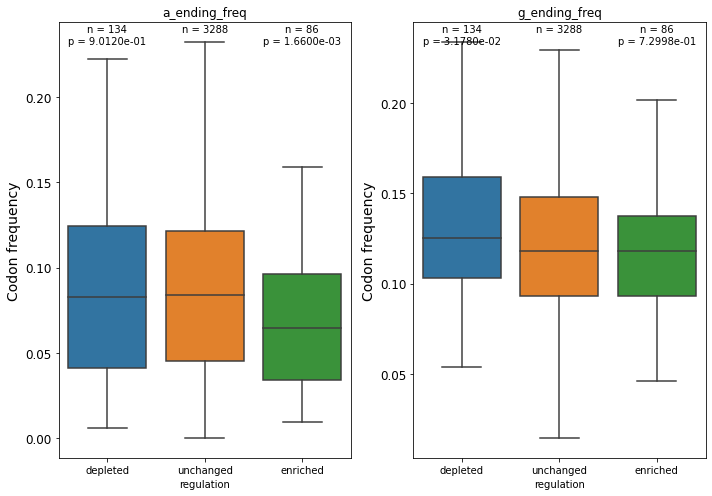

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind


fig, axs = plt.subplots(1, len(codons_of_interest))
df = agg_infos['pats vs ctrls'].copy()
df = df.loc[~df.pulldown_lfc.isna(), :]
for ax, k, codons in zip(axs, ['a_ending', 'g_ending'], codons_of_interest):
    df['regulation'] = pd.cut(
        df.pulldown_lfc,
        bins = [-3, -0.5, 0.5, 3],
        labels = ['depleted', 'unchanged', 'enriched']
    )
    title = k + '_freq'
    sns.boxplot(
        data = df,
        x = 'regulation',
        y = title,
        showfliers = False,
        ax = ax
    )
    ax.set_title(title)

    ax.tick_params(axis = 'y', labelsize = 12)
    ax.set_ylabel('Codon frequency', fontdict={'fontsize': 14})
                    
    _, ymax = ax.get_ylim()
    ctrl_values = df.loc[df.regulation == 'unchanged', title]
    for i, (g, gdata) in enumerate(df.groupby('regulation')):
        n = len(gdata)
        text = f'n = {n}'

        
        if g in ['depleted', 'enriched']:
            res = ttest_ind(gdata[title], ctrl_values,  nan_policy = 'omit')
            text += '\np = {:.4e}'.format(res.pvalue)
            
        ax.text(
            i, ymax - 0.001,
            text,
            va = 'top',
            ha = 'center'
        )        
        

fig.set_figwidth(5 * len(codons_of_interest))
fig.set_figheight(7)
fig.tight_layout()
fig.savefig('../plots/codon_frequency_both_patients.pdf')

In [12]:
pulldown = pd.read_excel(
    '../data/CC_AVi_172-M1158-F1-F5-P13031-1-OTITOT-SumInd_TotalPeptideNorm-16plex-AR-20230414-16plexQuan-filtered-patient-vs-control.xlsx',
    sheet_name='Proteins',
    usecols='D,J,AD,AE',
    names=['protein_id', 'gene_symbol', 'log2FC', 'adj_p_val']
)
pulldown.set_index('gene_symbol', inplace = True)
pulldown = pulldown.dropna(subset = ['log2FC'])
pulldown = pulldown.loc[pulldown.log2FC >= 0, :]
pulldown

,protein_id,log2FC,adj_p_val
gene_symbol,,,
IKBKB,O14920,0.00,0.991860
RRP12,Q5JTH9,0.00,0.930392
ATXN2L,Q8WWM7,0.00,0.908602
BNIP1,Q12981,0.00,0.914616
RAP2B,P61225,0.00,0.907521
...,...,...,...
UCHL1,P09936,1.51,0.437205
IGF2BP3,O00425,1.58,0.363204
ASS1,P00966,1.62,0.774463


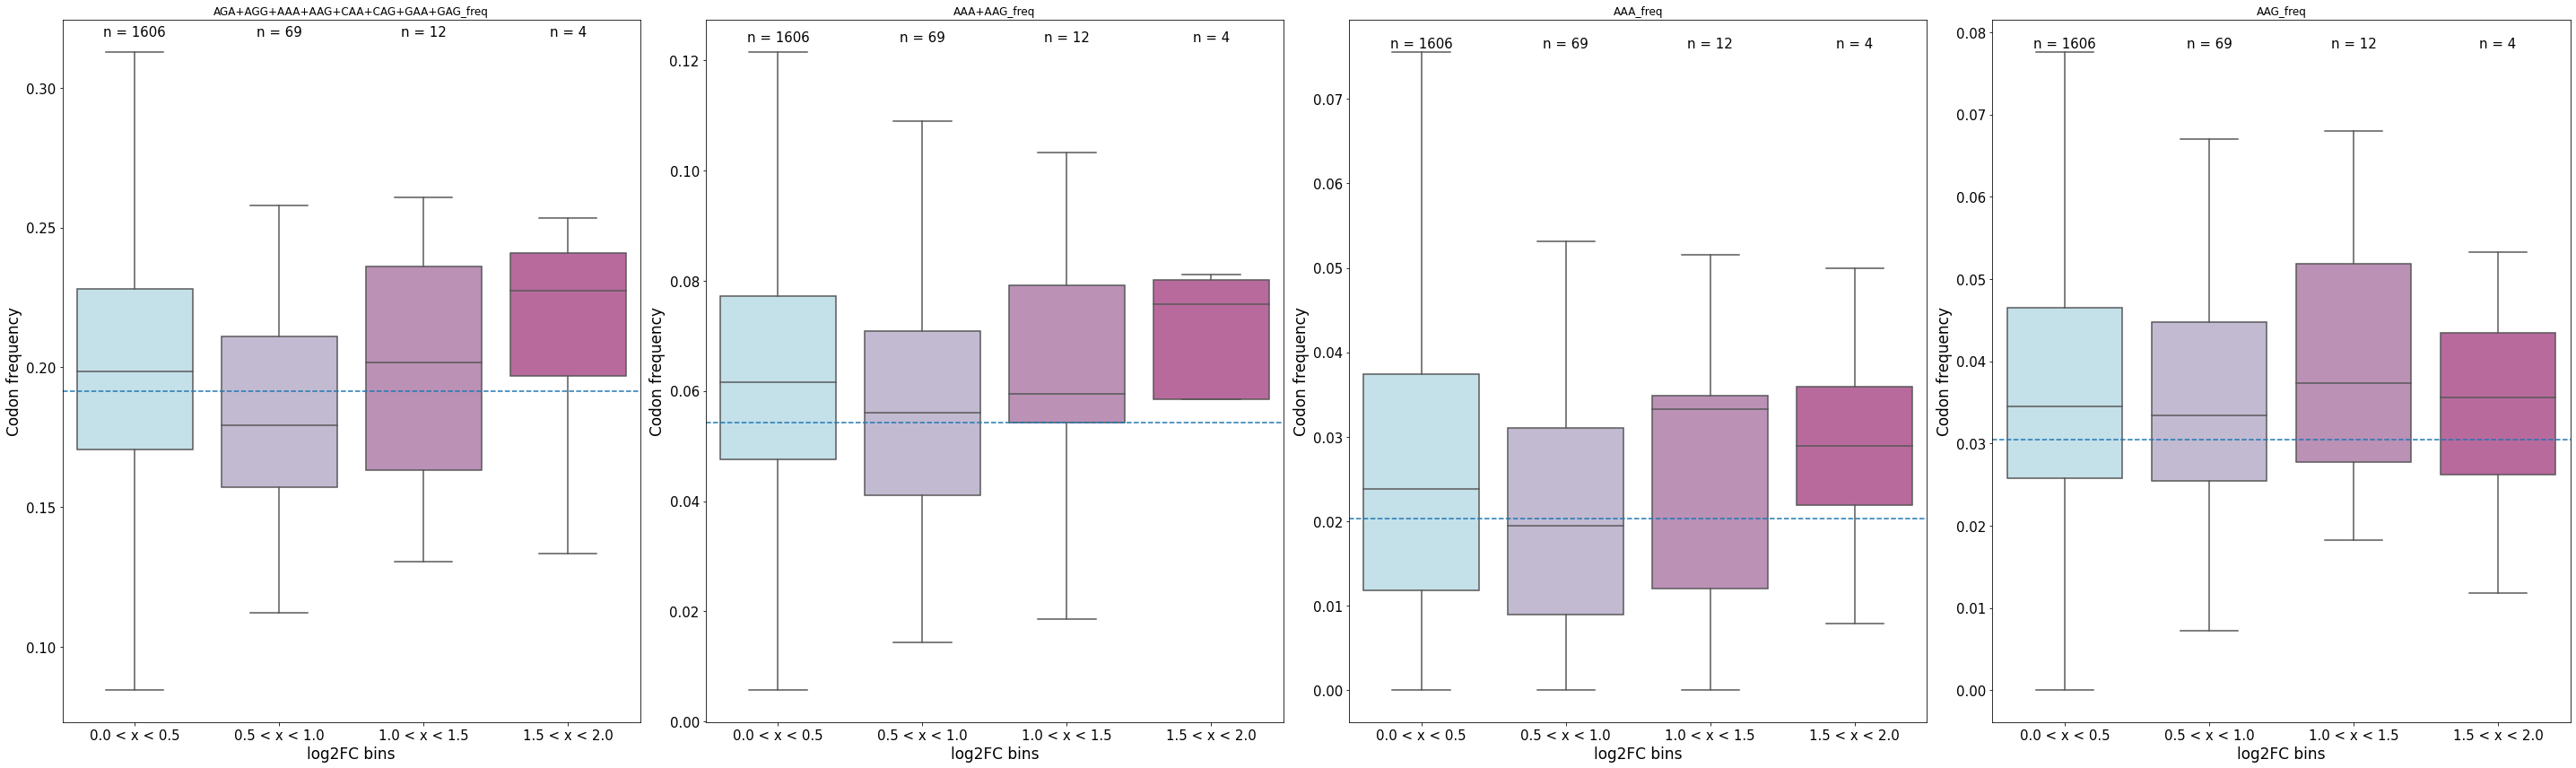

In [13]:
from matplotlib.colors import LinearSegmentedColormap

bins = np.linspace(0, 2, 5)
labels = [
    f'{bins[i]} < x < {bins[i+1]}' for i in range(len(bins) - 1)
]
pulldown['bins'] = pd.cut(
    pulldown.log2FC,
    bins = bins,
    labels = labels
)

data = accumulated_coi_freqs.merge(
    pulldown[['bins']],
    left_index = True,
    right_index = True,
    how = 'inner'
)

cmap = LinearSegmentedColormap.from_list('cmap', [(190/255, 227/255, 239/255), (199/255, 49/255, 136/255)], N = 256)
palette = {
    label: cmap(i/len(labels)) for i, label in enumerate(labels)
}

fig, axs = plt.subplots(1, len(codons_of_interest))
for ax, codons in zip(axs, codons_of_interest):
    title = '+'.join(codons) + '_freq'

    sns.boxplot(
        data = data,
        x = 'bins',
        y = title,
        showfliers = False,
        palette = palette,
        ax = ax
    )
    ax.set_title(title)

    ax.axhline(
        accumulated_coi_freqs[title].median(),
        ls = '--'
    )

    for i, (bin_, group) in enumerate(data.groupby('bins')):
        ax.text(
            i, ax.get_ylim()[1] - 0.002,
            f'n = {len(group)}',
            va = 'top',
            ha = 'center',
            fontsize = 15
        )

    ax.tick_params(axis = 'x', labelsize = 15)
    ax.set_xlabel('log2FC bins', fontdict={'fontsize': 17})

    ax.tick_params(axis = 'y', labelsize = 15)
    ax.set_ylabel('Codon frequency', fontdict={'fontsize': 17})

fig.set_figwidth(10 * len(codons_of_interest))
fig.set_figheight(12)
fig.tight_layout()
fig.savefig('../plots/codon_frequency_binned_all_patients.pdf')

In [14]:
import numpy as np
for codons in codons_of_interest:
    column = '+'.join(codons) + '_freq'
    accumulated_coi_freqs[f'{column}_enrichment'] = np.log2(
        accumulated_coi_freqs[column] / 
        accumulated_coi_freqs[column].mean()
    )
accumulated_coi_freqs

/Users/dmalzl/miniconda3/envs/mefisto/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dmalzl/miniconda3/envs/mefisto/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dmalzl/miniconda3/envs/mefisto/lib/python3.10/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,AGA+AGG+AAA+AAG+CAA+CAG+GAA+GAG_freq,AAA+AAG_freq,AAA_freq,AAG_freq,in_pulldown,AGA+AGG+AAA+AAG+CAA+CAG+GAA+GAG_freq_enrichment,AAA+AAG_freq_enrichment,AAA_freq_enrichment,AAG_freq_enrichment
NOC2L,0.228000,0.056000,0.008000,0.048000,False,0.222089,-0.034933,-1.602904,0.537415
PLEKHN1,0.158497,0.027778,0.001634,0.026144,False,-0.302492,-1.046429,-3.894507,-0.339151
HES4,0.130631,0.045045,0.013514,0.031532,False,-0.581452,-0.348992,-0.846573,-0.068824
ISG15,0.186747,0.048193,0.006024,0.042169,False,-0.065860,-0.251543,-2.012159,0.350552
C1orf159,0.110553,0.025126,0.010050,0.015075,False,-0.822210,-1.191201,-1.273744,-1.133425
...,...,...,...,...,...,...,...,...,...
PWWP4,0.149370,0.044132,0.014549,0.029583,False,-0.388059,-0.378538,-0.740057,-0.160855
ZNF275,0.234884,0.074419,0.018605,0.055814,False,0.265002,0.375303,-0.385312,0.755006
TSPY9,0.244444,0.038095,0.003175,0.034921,False,0.322562,-0.590750,-2.936327,0.078460
UTY,0.195362,0.061841,0.040759,0.021082,False,-0.000796,0.108208,0.746142,-0.649593


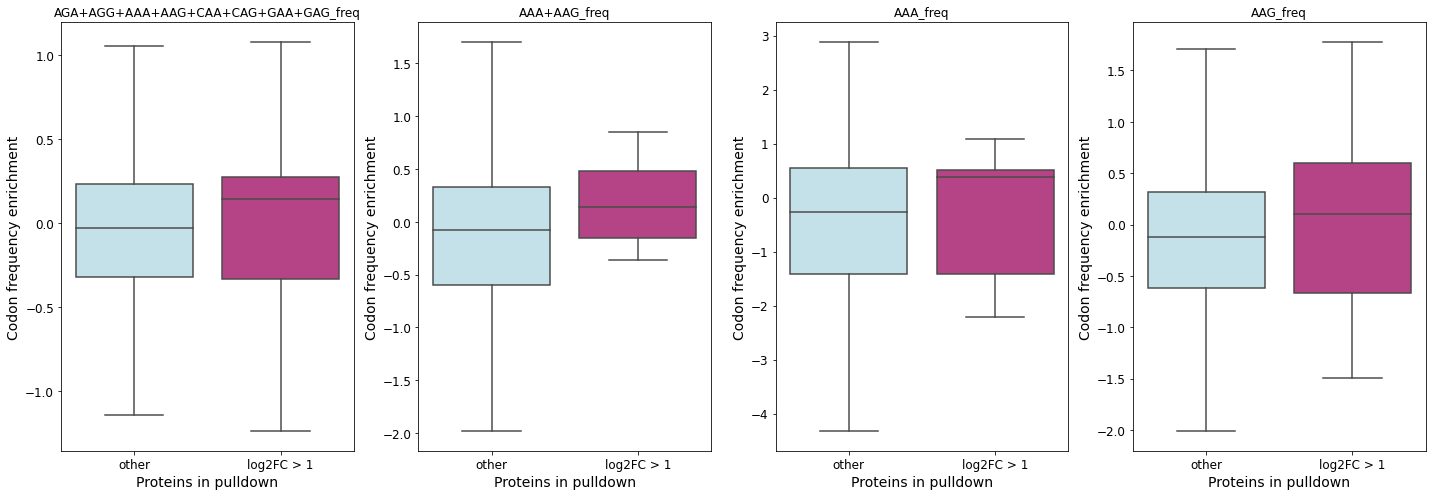

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

pulldown_genes = [
    'CDKN2A',
    'ETHE1',
    'ASS1',
    'IGF2BP3',
    'UCHL1',
    'ZNF185',
    'SCIN',
    'CRYBG1',
    'KIAA1522',
    'AHNAK2',
    'RASA4B',
    'HMGA1',
    'MSI2',
    'STXBP6',
    'LACC1',
    'SERPINE2',
    'HSPB6'
]

palette = {
    True: (199/255, 49/255, 136/255),
    False: (190/255, 227/255, 239/255)
}

accumulated_coi_freqs['in_pulldown'] = False
accumulated_coi_freqs.loc[pulldown_genes, 'in_pulldown'] = True
fig, axs = plt.subplots(1, len(codons_of_interest))
for ax, codons in zip(axs, codons_of_interest):
    title = '+'.join(codons) + '_freq'
    sns.boxplot(
        data = accumulated_coi_freqs,
        x = 'in_pulldown',
        y = title + '_enrichment',
        showfliers = False,
        palette = palette,
        ax = ax
    )
    
    ax.set_title(title)
    ax.set_xticklabels(['other', 'log2FC > 1'], fontdict={'fontsize': 12})
    ax.set_xlabel('Proteins in pulldown', fontdict={'fontsize': 14})

    ax.tick_params(axis = 'y', labelsize = 12)
    ax.set_ylabel('Codon frequency enrichment', fontdict={'fontsize': 14})

fig.set_figwidth(5 * len(codons_of_interest))
fig.set_figheight(7)
fig.tight_layout()
fig.savefig('../plots/codon_frequency_enrichment_all_patients.pdf')

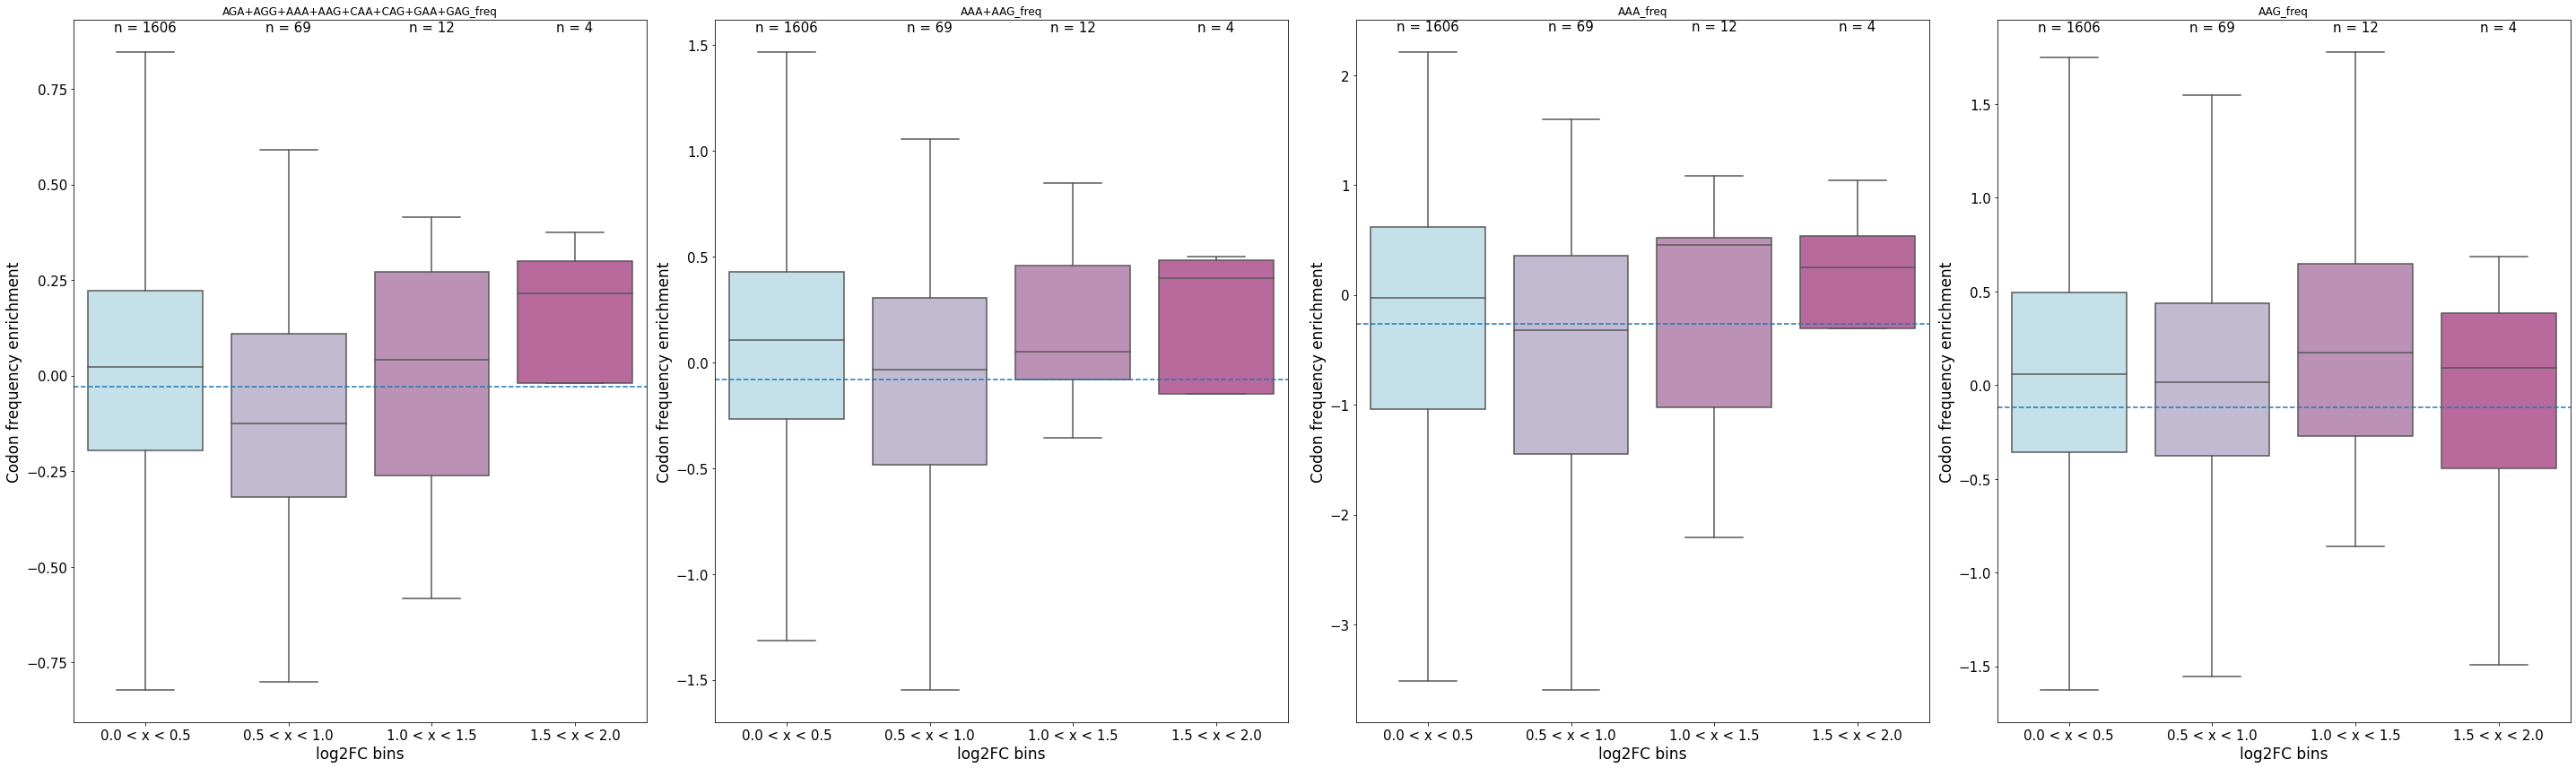

In [16]:
bins = np.linspace(0, 2, 5)
labels = [
    f'{bins[i]} < x < {bins[i+1]}' for i in range(len(bins) - 1)
]
pulldown['bins'] = pd.cut(
    pulldown.log2FC,
    bins = bins,
    labels = labels
)

data = accumulated_coi_freqs.merge(
    pulldown[['bins']],
    left_index = True,
    right_index = True,
    how = 'inner'
)
cmap = LinearSegmentedColormap.from_list('cmap', [(190/255, 227/255, 239/255), (199/255, 49/255, 136/255)], N = 256)
palette = {
    label: cmap(i/len(labels)) for i, label in enumerate(labels)
}

fig, axs = plt.subplots(1, len(codons_of_interest))
for ax, codons in zip(axs, codons_of_interest):
    title = '+'.join(codons) + '_freq'
    sns.boxplot(
        data = data,
        x = 'bins',
        y = title + '_enrichment',
        showfliers = False,
        palette = palette,
        ax = ax
    )
    
    ax.set_title(title)
    ax.axhline(
        accumulated_coi_freqs[title + '_enrichment'].median(),
        ls = '--'
    )

    for i, (bin_, group) in enumerate(data.groupby('bins')):
        ax.text(
            i, ax.get_ylim()[1] - 0.002,
            f'n = {len(group)}',
            va = 'top',
            ha = 'center',
            fontsize = 15
        )

    ax.tick_params(axis = 'x', labelsize = 15)
    ax.set_xlabel('log2FC bins', fontdict={'fontsize': 17})

    ax.tick_params(axis = 'y', labelsize = 15)
    ax.set_ylabel('Codon frequency enrichment', fontdict={'fontsize': 17})

fig.set_figwidth(10 * len(codons_of_interest))
fig.set_figheight(12)
fig.tight_layout()
fig.savefig('../plots/codon_frequency_enrichment_binned_all_patients.pdf')

In [18]:
import numpy as np
def compute_sliding_frequencies(cds, codons_of_interest, window_size = 30):
    window_frequencies = []
    for i in range(0, len(cds) - window_size, 3):
        counts = count_codons(cds[i:i+window_size])
        total_counts = sum(counts.values())
        counts_of_interest = sum(counts[codon] for codon in codons_of_interest)
        window_frequencies.append(counts_of_interest/total_counts * 100)
    
    return np.array(window_frequencies)


# compute clustered frequencies in sliding windows
sliding_codon_frequencies = {}
codons_of_interest = ['AAA', 'GAA', 'CAA', 'AGA']
for name, cds in cdss.items():
    sliding_codon_frequencies[name] = compute_sliding_frequencies(
        cds, 
        codons_of_interest, 
        window_size = 30
    )

In [19]:
# compute mean clustered frequency
sliding_frequency_sum = 0
num_sliding_windows = 0
for sliding_window_values in sliding_codon_frequencies.values():
    num_sliding_windows += len(sliding_window_values)
    sliding_frequency_sum += sliding_window_values.sum()

mean_sliding_frequency = sliding_frequency_sum / num_sliding_windows

# compute the number of sliding windows with freq larger mean and normalize by number of sliding windows
# the normalization is necessary to mitigate the influence of CDS length
codon_cluster_enrichment = {
    name: (sliding_window_values > mean_sliding_frequency).sum() / len(sliding_window_values) for name, sliding_window_values in sliding_codon_frequencies.items()
}
    
codon_cluster_enrichment = pd.DataFrame.from_dict(
    codon_cluster_enrichment, 
    orient = 'index', 
    columns=['enrichment']
)
codon_cluster_enrichment

,enrichment
NOC2L,0.395946
PLEKHN1,0.192691
HES4,0.174528
ISG15,0.211538
C1orf159,0.253968
...,...
PWWP4,0.294834
ZNF275,0.426190
TSPY9,0.363934
UTY,0.707006


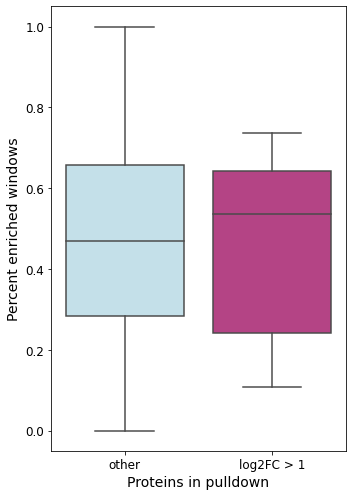

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
pulldown_genes = [
    'CDKN2A',
    'ETHE1',
    'ASS1',
    'IGF2BP3',
    'UCHL1',
    'ZNF185',
    'SCIN',
    'CRYBG1',
    'KIAA1522',
    'AHNAK2',
    'RASA4B',
    'HMGA1',
    'MSI2',
    'STXBP6',
    'LACC1',
    'SERPINE2',
    'HSPB6'
]
palette = {
    True: (199/255, 49/255, 136/255),
    False: (190/255, 227/255, 239/255)
}
codon_cluster_enrichment['in_pulldown'] = False
codon_cluster_enrichment.loc[pulldown_genes, 'in_pulldown'] = True
fig, ax = plt.subplots()
sns.boxplot(
    data = codon_cluster_enrichment,
    x = 'in_pulldown',
    y = 'enrichment',
#     showfliers = False,
    palette = palette,
    ax = ax
)
ax.set_xticklabels(['other', 'log2FC > 1'], fontdict={'fontsize': 12})
ax.set_xlabel('Proteins in pulldown', fontdict={'fontsize': 14})

ax.tick_params(axis = 'y', labelsize = 12)
ax.set_ylabel('Percent enriched windows', fontdict={'fontsize': 14})

fig.set_figwidth(5)
fig.set_figheight(7)
fig.tight_layout()
fig.savefig('../plots/codon_cluster_enrichment.pdf')

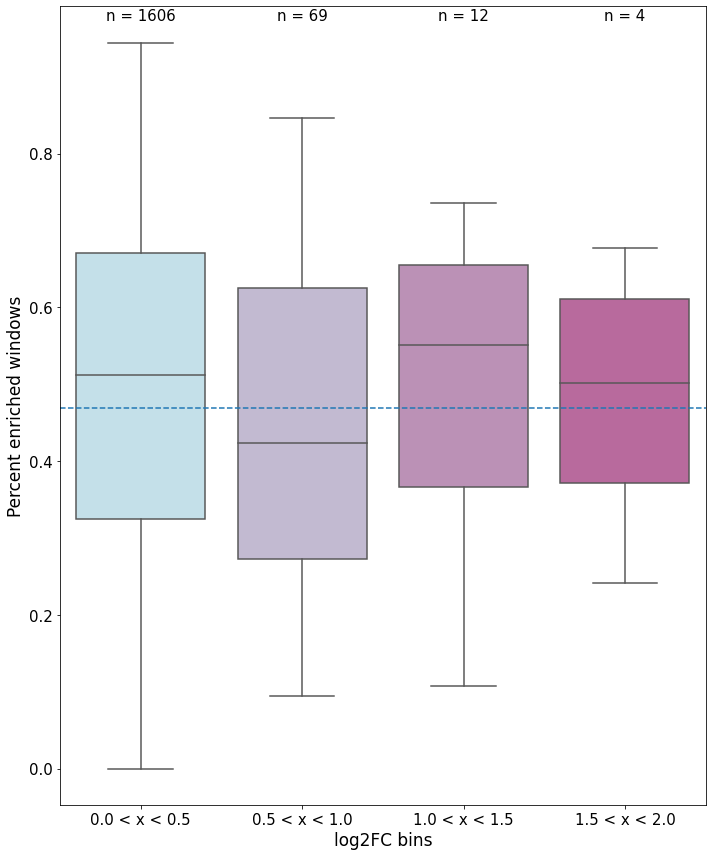

In [21]:
bins = np.linspace(0, 2, 5)
labels = [
    f'{bins[i]} < x < {bins[i+1]}' for i in range(len(bins) - 1)
]
pulldown['bins'] = pd.cut(
    pulldown.log2FC,
    bins = bins,
    labels = labels
)

data = codon_cluster_enrichment.merge(
    pulldown[['bins']],
    left_index = True,
    right_index = True,
    how = 'inner'
)
cmap = LinearSegmentedColormap.from_list('cmap', [(190/255, 227/255, 239/255), (199/255, 49/255, 136/255)], N = 256)
palette = {
    label: cmap(i/len(labels)) for i, label in enumerate(labels)
}

fig, ax = plt.subplots()
sns.boxplot(
    data = data,
    x = 'bins',
    y = 'enrichment',
    showfliers = False,
    palette = palette,
    ax = ax
)

ax.axhline(
    codon_cluster_enrichment.enrichment.median(),
    ls = '--'
)

for i, (bin_, group) in enumerate(data.groupby('bins')):
    ax.text(
        i, ax.get_ylim()[1] - 0.002,
        f'n = {len(group)}',
        va = 'top',
        ha = 'center',
        fontsize = 15
    )

ax.tick_params(axis = 'x', labelsize = 15)
ax.set_xlabel('log2FC bins', fontdict={'fontsize': 17})

ax.tick_params(axis = 'y', labelsize = 15)
ax.set_ylabel('Percent enriched windows', fontdict={'fontsize': 17})

fig.set_figwidth(10)
fig.set_figheight(12)
fig.tight_layout()
fig.savefig('../plots/codon_cluster_enrichment_binned.pdf')

In [22]:
pulldown_genes = pulldown.loc[pulldown.log2FC > 0.5, 'gene_symbol'].to_list()
for gene in pulldown_genes:
    print(gene, sliding_codon_frequencies[gene])

KeyError: 'gene_symbol'